In [1]:
import pandas as pd
import matplotlib.pyplot as mltp
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import sklearn as sk
import seaborn as sea
import re 
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Laden der Inhalte aus den vorbereiteten Daten rein, welche basierend auf de Wortanzahl aber auch Sätzen selektiert wurden

In [2]:
def stripping(liste):
    return [i.strip() for i in liste]

In [3]:
df=pd.read_csv('data/train_500.csv',converters={'sent_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize_without_stopwords': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'word_tokenize_without_stopwords_port': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'msg_lemmatized': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
})

df['word_tokenize']=df['word_tokenize'].progress_apply(stripping)
df['sent_tokenize']=df['sent_tokenize'].progress_apply(stripping)
df['word_tokenize_without_stopwords']=df['word_tokenize_without_stopwords'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

In [4]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.reset_index(drop=True)

In [5]:
print(f'Rows in the df: {len(df.index)}')

Rows in the df: 19500


In [6]:
import random
import string
import nltk
from nltk import ngrams as get_ngrams


start_of_seq_token = "<START>"


class NgramModel(object):
    def __init__(self, n):
        self.n = n

        # dictionary that keeps list of candidate words given context
        self.context = {}
        self.ngram_counter_without_pre = {}

        # keeps track of how many times ngram has appeared in the text before
        self.ngram_counter = {}
        self.unique_count={}
        self.listen_append=[]


    def update(self, sentence: str,liste:list):
        """
        Updates the language model with an additional sentence (string)
        :param sentence: input text
        """
        liste=liste
        n = self.n
        sentence = (n-1) * [start_of_seq_token] + [w for w in nltk.word_tokenize(sentence) if w not in string.punctuation]
        ngrams = get_ngrams(sentence, n)
        for ngram in ngrams:
            #print(ngram)
            prev_words, target_word = ngram[:-1], ngram[-1]
            if (prev_words, target_word) in self.ngram_counter:
                self.ngram_counter[(prev_words, target_word)] += 1.0
            else:
                self.ngram_counter[(prev_words, target_word)] = 1.0


            if target_word in self.unique_count and target_word not in liste:
                liste.append(target_word)
                self.unique_count[target_word] += 1.0
                #print(1)

            elif target_word in self.unique_count and target_word  in liste:
                #print(2)
                pass
                
            else:
                #print(3)
                self.unique_count[target_word] = 1.0

            if target_word in self.ngram_counter_without_pre:
                
                self.ngram_counter_without_pre[target_word] += 1.0
            else:
                self.ngram_counter_without_pre[target_word] = 1.0

            if prev_words in self.context:
                if target_word not in self.context[prev_words]:
                    self.context[prev_words].append(target_word)
                else:
                    pass
            else:
                self.context[prev_words] = [target_word]
        return liste

    
    def prob(self, context, token):
        """
        Calculates probability of a candidate token to be generated given a context
        :return: conditional probability
        """
        try:
            count_of_token = self.ngram_counter[(context, token)]
            count_of_context = float(len(self.context[context]))
            result = count_of_token / count_of_context

        except KeyError:
            result = 0.0
            
        return result
    
    def random_token(self, context):
        """
        Given a context, selects the next word to append in a sequence
        :param context:
        :return:
        """
        r = random.random() / 50
        map_to_probs = {}
        token_of_interest = self.context[context]
        for token in token_of_interest:
            map_to_probs[token] = self.prob(context, token)

        summ = 0
        for token in sorted(map_to_probs):
            summ += map_to_probs[token]
            if summ > r:
                return token
        
        return next(sorted(map_to_probs))

    def generate_text(self, token_count: int):
        """
        :param token_count: number of words to be produced
        :return: generated text
        """
        n = self.n
        context_queue = (n - 1) * [start_of_seq_token]
        result = []
        for _ in range(token_count):
            obj = self.random_token(tuple(context_queue))
            result.append(obj)
            if n > 1:
                context_queue.pop(0)
                if obj == '.':
                    context_queue = (n - 1) * [start_of_seq_token]
                else:
                    context_queue.append(obj)
        return ' '.join(result)

In [7]:
model = NgramModel(n=2)
for x in tqdm(range(len(df.index))):
#for x in tqdm(range(3)):  
    sentences = [sent for sent in nltk.sent_tokenize(df['text'][x]) if sent]
    
    liste=[]
    for sent in sentences:
        #num=1
        #print(sent)
        liste=model.update(sent,liste)
        #liste=model.clac(sent,liste)
    #print(liste)

    
print(len(model.unique_count))

  0%|          | 0/19500 [00:00<?, ?it/s]

121338


Die Texte werden basierend auf ihren Inhalten analysiert, wobei die Wortanazahl gesamt, sowie des Auftretens der unterschiedlichen Texte Analysiert wird.

In [8]:
words_in_texts=pd.DataFrame(model.ngram_counter_without_pre,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
words_in_texts.head()

,word,num
0,This,3141.0
1,blog,2000.0
2,is,33051.0
3,being,2866.0
4,posted,339.0


In [9]:
words_in_texts=words_in_texts.loc[:, ~words_in_texts.columns.str.contains('^Unnamed')]
words_in_texts.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [10]:
count_overview=pd.DataFrame(model.unique_count,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
count_overview.to_csv('data/count_overview.csv')

In [11]:
count_overview=pd.read_csv('data/count_overview.csv')
count_overview=count_overview.loc[:, ~count_overview.columns.str.contains('^Unnamed')]
count_overview.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0


In [12]:
count_overview.sort_values(by= 'num',ascending=False).head(20)

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [13]:
count_ordnung=count_overview.sort_values(by= 'num',ascending=False)

In [14]:
words_that_are_often=count_ordnung[count_ordnung['num']>6000]
words_that_are_often

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [15]:
words_in_texts=words_in_texts.sort_values(by= 'num',ascending=False)
words_in_texts.head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [16]:
words_in_texts[words_in_texts['num']>7000]

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0
...,...,...
72,know,7559.0
43,if,7316.0
181,by,7199.0
327,would,7052.0


In [17]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 17.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [18]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(df.text.tolist()):
    doc = nlp(text)
    text_list_word=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #print(text_list)
d = {'text':df.text.tolist(),'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list,'gender':df.gender.tolist(),'sign':df.sign.tolist(),'topic':df.topic.tolist()}
df_text_spacy=pd.DataFrame(data=d)
    


  0%|          | 0/19500 [00:00<?, ?it/s]

In [19]:
df_text_spacy.head()

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,gender,sign,topic
0,This blog is being posted due to the fact that...,"[This, blog, is, being, posted, due, to, the, ...","[this, blog, be, be, post, due, to, the, fact,...","[DET, NOUN, AUX, AUX, VERB, ADP, ADP, DET, NOU...","[DT, NN, VBZ, VBG, VBN, IN, IN, DT, NN, IN, JJ...","[det, nsubjpass, aux, auxpass, ROOT, prep, pco...","[Xxxx, xxxx, xx, xxxx, xxxx, xxx, xx, xxx, xxx...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",male,Sagittarius,Student
1,So I have a big fucking interview tomorrow for...,"[So, I, have, a, big, fucking, interview, tomo...","[so, I, have, a, big, fucking, interview, tomo...","[ADV, PRON, VERB, DET, ADJ, ADJ, NOUN, NOUN, A...","[RB, PRP, VBP, DT, JJ, JJ, NN, NN, IN, PRP$, J...","[advmod, nsubj, ROOT, det, amod, amod, dobj, n...","[Xx, X, xxxx, x, xxx, xxxx, xxxx, xxxx, xxx, x...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",male,Pisces,Student
2,I was reminded just now of the time Ashley and...,"[I, was, reminded, just, now, of, the, time, A...","[I, be, remind, just, now, of, the, time, Ashl...","[PRON, AUX, VERB, ADV, ADV, ADP, DET, NOUN, PR...","[PRP, VBD, VBN, RB, RB, IN, DT, NN, NNP, CC, P...","[nsubjpass, auxpass, ROOT, advmod, advmod, pre...","[X, xxx, xxxx, xxxx, xxx, xx, xxx, xxxx, Xxxxx...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, True, Fa...",female,Gemini,Student
3,I was checking up on my cousin Dylan and Fanni...,"[I, was, checking, up, on, my, cousin, Dylan, ...","[I, be, check, up, on, my, cousin, Dylan, and,...","[PRON, AUX, VERB, ADP, ADP, PRON, NOUN, PROPN,...","[PRP, VBD, VBG, RP, IN, PRP$, NN, NNP, CC, NNP...","[nsubj, aux, ROOT, prt, prep, poss, pobj, poss...","[X, xxx, xxxx, xx, xx, xx, xxxx, Xxxxx, xxx, X...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, False, F...",female,Taurus,Student
4,for the NME interview click urlLink part 1 and...,"[for, the, NME, interview, click, urlLink, par...","[for, the, NME, interview, click, urllink, par...","[SCONJ, DET, PROPN, NOUN, VERB, NOUN, NOUN, NU...","[IN, DT, NNP, NN, VB, NN, NN, CD, CC, VB, NN, CD]","[mark, det, compound, nsubj, ROOT, dobj, dobj,...","[xxx, xxx, XXX, xxxx, xxxx, xxxXxxx, xxxx, d, ...","[True, True, True, True, True, True, True, Fal...","[True, True, False, False, False, False, True,...",female,Aquarius,Student


In [20]:
from nltk.corpus import stopwords
def stopwords_count_and_removal(data, col, language="english"):

    stoplist = stopwords.words(language)

    number_of_stopwords = []
    text_without_stopwords = []

    col_name_number_of_stopwords = col + "_num_of_stopwords"
    col_name_without_stopwords = col + "_without_stopwords"

    for i in tqdm(range(len(data))):
        no_of_words = 0
        without_stopwords = []
        for word in data[col][i]:
            if word in stoplist:
                no_of_words += 1
            else:
                without_stopwords.append(word)
        
        text_without_stopwords.append(without_stopwords)
        number_of_stopwords.append(no_of_words)

    data[col_name_number_of_stopwords] = number_of_stopwords
    data[col_name_without_stopwords] = text_without_stopwords


    return data

In [21]:
df_text_spacy=stopwords_count_and_removal(df_text_spacy,'lemma_list')

  0%|          | 0/19500 [00:00<?, ?it/s]

# LDA

In [126]:
import numpy as np
import json
import glob

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import pickle 

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

Stoppwörter sind häufig vorkommende Wörter in einer Sprache, die für sich genommen nicht viel Bedeutung haben und bei der Verarbeitung natürlicher Sprache (NLP) häufig entfernt werden. Zu diesen Wörtern gehören u. a. Artikel, Konjunktionen und Präpositionen.

Es gibt mehrere Gründe, warum Stoppwörter im NLP häufig entfernt werden. Ein Grund ist, dass Stoppwörter keinen großen Informationsgehalt haben und nicht wesentlich zur Bedeutung eines Satzes beitragen. Daher kann das Entfernen von Stoppwörtern den Umfang des Wortschatzes verringern und die Verarbeitung des Textes erleichtern.

Ein weiterer Grund für die Entfernung von Stoppwörtern ist, dass sie bei bestimmten NLP-Aufgaben stören können. Bei Aufgaben der Informationsbeschaffung, wie z. B. Suchmaschinen, können Stoppwörter besonders problematisch sein, da sie so häufig vorkommen und kaum nützliche Informationen für die Einstufung von Suchergebnissen liefern. In solchen Fällen kann das Entfernen von Stoppwörtern die Leistung des Systems verbessern.

Zusammenfassend lässt sich sagen, dass Stoppwörter bei NLP-Aufgaben oft entfernt werden, welches in diesem Fall getan wird, weil sie kaum Informationen enthalten, bestimmte Aufgaben behindern und die Verarbeitung des Textes erleichtern können. Es gibt zwar Situationen, in denen Stoppwörter nützlich sein können, aber im Allgemeinen werden sie nicht als so wichtig angesehen wie andere Wörter in einem Satz und werden oft als Vorverarbeitungsschritt entfernt.


In [127]:
stopwords = stopwords.words('english')

In [128]:
text_liste=df_text_spacy.text.tolist()
text_liste[0][0:90]

'This blog is being posted due to the fact that little development has happened recently re'

SpaCy ist eine beliebte Open-Source-Bibliothek für die Verarbeitung natürlicher Sprache (NLP) in Python. Sie enthält unter anderem Werkzeuge für Tokenisierung, Part-of-Speech-Tagging, Dependency Parsing und Named Entity Recognition. Diese Werkzeuge sind in einer Pipeline organisiert, die den Eingabetext verarbeitet und eine Vielzahl von linguistischen Merkmalen extrahiert, die für eine Vielzahl von NLP-Aufgaben verwendet werden können.

Der erste Schritt in der SpaCy-Pipeline ist die Tokenisierung, d. h. die Zerlegung des Eingabetextes in einzelne Wörter (Token). Dies geschieht anhand einer Reihe von Regeln, die Interpunktion, Kontraktionen und andere Sonderfälle berücksichtigen. Die so entstandenen Token werden dann mit verschiedenen linguistischen Merkmalen versehen, z. B. mit ihrem Part-of-Speech-Tag und ihrem Lemma (Grundform).

Der nächste Schritt in der Pipeline ist das Part-of-Speech-Tagging, bei dem jedes Token mit seinem Part of Speech (z. B. Substantiv, Verb oder Adjektiv) gekennzeichnet wird. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Part-of-Speech-Tagging ist ein wichtiger Schritt, da es dem Modell ermöglicht, die grammatikalische Rolle jedes Wortes im Satz zu identifizieren, was für Aufgaben wie Dependency Parsing und Named Entity Recognition nützlich sein kann.

Beim Dependency Parsing werden die Beziehungen zwischen Wörtern in einem Satz identifiziert, z. B. Subjekt-Verben-Beziehungen und Modifikator-Kopf-Beziehungen. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Parsen von Abhängigkeiten ist ein wichtiger Schritt, da es dem Modell ermöglicht, die Struktur des Satzes und die Beziehungen zwischen den Wörtern zu verstehen, was für Aufgaben wie die Informationsextraktion und die maschinelle Übersetzung nützlich sein kann. Jedoch wird dies Aufgrund der Anwendung ncith verwendet, da dies meist mit den höchsten Aufwand erzeugt

Bei der Erkennung benannter Entitäten handelt es sich um den Prozess der Identifizierung und Klassifizierung benannter Entitäten in Texten, z. B. Personen, Organisationen und Orte. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen kommentierten Textkorpus trainiert wurde. Die Erkennung von benannten Entitäten ist ein wichtiger Schritt, da sie es dem Modell ermöglicht, strukturierte Informationen aus unstrukturiertem Text zu extrahieren, was für Aufgaben wie die Informationsextraktion und die Textklassifizierung nützlich sein kann.

Insgesamt ist die SpaCy-Pipeline ein leistungsfähiges Werkzeug zur Extraktion einer Vielzahl von linguistischen Merkmalen aus Text, die für eine Vielzahl von NLP-Aufgaben verwendet werden können. Durch die Kombination dieser Merkmale mit Modellen des maschinellen Lernens ist es möglich, anspruchsvolle NLP-Anwendungen zu erstellen, die natürlichsprachliche Texte analysieren und verstehen können.


In [129]:
def lemmatization_test(texts,  allowed_posttags=['NOUN','ADJ','VERB','ADV']):
    nlp=spacy.load('en_core_web_md',disable=['parser','ner'])
    texts_out=[]
    for text in tqdm(texts):
        doc= nlp(text)
        new_text=[]
        for token in doc:
            if token.pos_ in allowed_posttags:
                new_text.append(token.lemma_)
        final=' '.join(new_text)
        texts_out.append(final)
    return texts_out

In [130]:
lemma_text=lemmatization_test(text_liste)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [131]:
print(lemma_text[0][0:90])

blog post fact little development happen recently regard last day school uniform swap plan


In [132]:
def gen_words(texts):
    final=[]
    for text in tqdm(texts):
        new= gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
    return final

In [133]:
data_words=gen_words(lemma_text)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [134]:
print(data_words[0][0:90])

['blog', 'post', 'fact', 'little', 'development', 'happen', 'recently', 'regard', 'last', 'day', 'school', 'uniform', 'swap', 'plan', 'switch', 'uniform', 'certain', 'individual', 'somehow', 'organize', 'soon', 'also', 'consider', 'last', 'day', 'school', 'think', 'participate', 'success', 'plan', 'soon', 'pray', 'drop', 'dress', 'code', 'day', 'last', 'day', 'school']


### Bigrams and Trigrams

Ein n-Gramm ist eine zusammenhängende Sequenz von n Elementen aus einer bestimmten Text- oder Sprachprobe. N-Gramme sind in der natürlichen Sprachverarbeitung und Computerlinguistik weit verbreitet. Sie können für eine Vielzahl von Aufgaben verwendet werden, z. B. für die Sprachmodellierung, die Informationsbeschaffung und die maschinelle Übersetzung.

Bigramme sind Zwei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Bigramme zum Beispiel "die Katze", "Katze in" und "in der". Bigramme können für Aufgaben wie Rechtschreibkorrektur, Sprachmodellierung und Informationsabfrage nützlich sein.

Trigramme sind Drei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Trigramme zum Beispiel "die Katze in", "die Katze im" und "im Hut". Trigramme können für Aufgaben wie Sprachmodellierung und Informationsabfrage nützlich sein.

N-Gramme werden häufig in der natürlichen Sprachverarbeitung verwendet, da sie den Kontext und die Bedeutung von Wörtern in einem Text erfassen können. Beispielsweise ist das Bigramm "New York" informativer als die einzelnen Wörter "New" und "York", da es darauf hindeutet, dass die beiden Wörter miteinander verwandt sind und sich wahrscheinlich auf die Stadt beziehen. In ähnlicher Weise ist das Trigramm "die Katze in" informativer als die Bigramme "die Katze" und "Katze in", da es darauf hindeutet, dass die Wörter Teil einer Sequenz sind und wahrscheinlich in irgendeiner Weise miteinander in Beziehung stehen.

Insgesamt können n-Gramme ein nützliches Werkzeug für das Verständnis und die Verarbeitung von Sprachdaten sein, und Bigramme und Trigramme werden häufig in einer Vielzahl von Aufgaben der natürlichen Sprachverarbeitung verwendet.


In [135]:
bigram_phrases=gensim.models.Phrases(data_words,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words)
data_bigrams_trigrams=make_trgram(data_bigrams)

In [136]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

Ein wichtiger aber auch schwieriger Aspekt des LDA prozesses ist die Bestimmung der ANzhal der Topics. Hierbei ist wie bei Maschine Learning eine autonmatische Verbesserung und Lernen nicht gegeben, weshlab durch erforschen und Analysen die Optimalen Parameter gefunden werden müssen. Dies ist besonders schweirig, da meist Klassen entstehen, welche eine hohe Anzahl an Elementen enthalten

In [137]:
num_topics=76

In [138]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [139]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.9560000000000003, 1: 0.9260000000000004, 2: 0.9120000000000004, 3: 0.9240000000000003, 4: 0.8979999999999999, 5: 0.9220000000000004, 6: 0.0, 7: 0.8780000000000002, 8: 0.933, 9: 0.8610000000000001, 10: 0.83, 11: 0.9440000000000003, 12: 0.894, 13: 1.0010000000000006, 14: 0.8210000000000001, 15: 0.9410000000000002, 16: 0.9310000000000004, 17: 0.0, 18: 0.9440000000000004, 19: 0.9360000000000002, 20: 0.9810000000000003, 21: 0.0, 22: 0.8750000000000002, 23: 0.9430000000000001, 24: 0.9150000000000001, 25: 0.9230000000000002, 26: 0.9040000000000001, 27: 0.971, 28: 0.918, 29: 0.719, 30: 0.883, 31: 0.8840000000000003, 32: 0.9480000000000004, 33: 0.8690000000000001, 34: 0.8880000000000003, 35: 0.8879999999999999, 36: 0.827, 37: 0.9850000000000001, 38: 0.8530000000000003, 39: 0.9120000000000004, 40: 0.9420000000000004, 41: 0.9080000000000001, 42: 0.9560000000000004, 43: 0.9810000000000002, 44: 0.9630000000000002, 45: 0.356, 46: 0.9260000000000004, 47: 0.9700000000000006, 48: 0.95800000000000

Zur bestimmung der optimalen Anzahl von relevanten Wörtern wurden daher auf 100 gestzt, um nah an 100% zu sein. Da je nach Wort eine untershciedliche Wahrscheinlichkeit und Somit gewichtung für das eine oder andere Topic entsteht

Daher werden die Wörter im nahchinein genutzt, um eine zurodnung durch abgleich und multiplikation der Gewichtung zu erziehlen, um basierend davon jenes Topic zu deklarieren, welches am Wahrscheinlichsten ist. Aus diesem Grund dies aus dem Wert der Summe der auftretenden Werte verglichen mit der Summe der Unterschiedlichen Gewichte mäglicher alternastiven Topics
Dafür wird volgendes getan:
1. Identifizieren, welche Wörter eines Topics und wei oft in einem Text enthalten sind
2. Basierend auf diesen die Wahrscheinlihckeiten bestimmen
3. Diese Addieren und den höchsten Wert identifizieren, welche das Wahrschienlichste Topic entspricht


In [140]:
df_topic=pd.DataFrame(data=dic)
df_topic.head()

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,71_word,71_per,72_word,72_per,73_word,73_per,74_word,74_per,75_word,75_per
0,want,0.373,thought,0.100,use,0.432,fall,0.144,car,0.248,...,thing,0.726,heart,0.148,love,0.390,thank,0.311,write,0.270
1,forget,0.078,student,0.084,shop,0.067,moment,0.116,drive,0.223,...,sometimes,0.108,shit,0.140,life,0.333,pass,0.169,read,0.242
2,learn,0.072,grow,0.075,promise,0.048,kill,0.106,break,0.199,...,pain,0.067,hurt,0.108,ve,0.055,totally,0.105,book,0.159
3,hold,0.071,apparently,0.068,mostly,0.045,weather,0.074,road,0.090,...,thousand,0.011,beat,0.096,dead,0.045,random,0.055,list,0.064
4,question,0.063,lead,0.064,letter,0.042,perfect,0.073,sweet,0.076,...,comfort,0.008,report,0.079,sex,0.038,correct,0.044,page,0.051


In [141]:
def create_df_overview(data_words,num_topics,df_topic):
    topic_of_text=[]
    for text in tqdm(data_words):
        liste_text_top=[]
        for t in range(num_topics):
            liste_top=[]
            for element in df_topic[f'{t}_word'].tolist():
                liste_top.append(len([i for i, e in enumerate(text) if e == element]))
    
            Result = []
            for i1, i2 in zip(liste_top, df_topic[f'{t}_per'].tolist()):
                Result.append(i1*i2)
            liste_text_top.append(sum(Result))    
        if sum(liste_text_top)!=0:
            topic_of_text.append([max(range(len(liste_text_top)), key=liste_text_top.__getitem__),max(liste_text_top)/sum(liste_text_top),liste_text_top])
        else:
            topic_of_text.append(['None','None',liste_text_top])
    return pd.DataFrame(data=topic_of_text,columns=['topic_num','percent','perc_list'])
       


In [142]:
overview=pd.merge(df[['text','topic']], create_df_overview(data_words,num_topics,df_topic), left_index=True, right_index=True)
overview.head()

  0%|          | 0/19500 [00:00<?, ?it/s]

,text,topic,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,9,0.258929,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0,..."
1,So I have a big fucking interview tomorrow for...,Student,37,0.261361,"[0.063, 0.0, 0.432, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,I was reminded just now of the time Ashley and...,Student,27,0.187367,"[1.119, 0.0, 0.0, 0.064, 0.719, 0.0, 0.0, 0.17..."
3,I was checking up on my cousin Dylan and Fanni...,Student,48,0.196437,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,for the NME interview click urlLink part 1 and...,Student,52,0.940789,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


- ml --> prediction welches richtige topic man hat --> meist mehr topics --> ggf noch pca --> (downstream task) --> klassifikation
- einrichtigen text --> grundlagen teil und praxis teil 

In [143]:
# Build App
import socket
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output

In [144]:

def vis_topic(overview):
    sock = socket.socket()
    sock.bind(('', 0))
    sock.getsockname()[1]
    app = JupyterDash(__name__)
    app.layout = html.Div([
        html.H1("Übersicht der Verteilungen basierend auf den initialen Topics"),
        dcc.Graph(id='graph'),
        html.Label([
            "Topics",
            dcc.Dropdown(
                id='colorscale-dropdown', clearable=False,
                value='plasma', options=[
                    {'label': c, 'value': c}
                    for c in overview['topic'].unique().tolist()
                ]
                )
        ]),
    ])
    # Define callback to update graph
    @app.callback(
        Output('graph', 'figure'),
        [Input("colorscale-dropdown", "value")]
    )
    def update_figure(colorscale):
        testdf = overview[overview['topic']==colorscale].topic_num.value_counts().rename_axis('unique_values').reset_index(name='counts')
        return px.pie(testdf, values='counts', names='unique_values')
    # Run app and display result inline in the notebook
    app.run_server(mode='inline', port=sock.getsockname()[1])


In [145]:
def vis_topic_num(overview):
    sock = socket.socket()
    sock.bind(('', 0))
    sock.getsockname()[1]
    app = JupyterDash(__name__)
    app.layout = html.Div([
        html.H1("Übersicht der Verteilungen basierend auf den initialen Topics"),
        dcc.Graph(id='graph'),
        html.Label([
            "Topics",
            dcc.Dropdown(
                id='colorscale-dropdown', clearable=False,
                value='plasma', options=[
                    {'label': c, 'value': c}
                    for c in overview['topic_num'].unique().tolist()
                ]
                )
        ]),
    ])
    # Define callback to update graph
    @app.callback(
        Output('graph', 'figure'),
        [Input("colorscale-dropdown", "value")]
    )
    def update_figure(colorscale):
        testdf = overview[overview['topic_num']==colorscale].topic.value_counts().rename_axis('topic').reset_index(name='counts')
        return px.pie(testdf, values='counts', names='topic')
    # Run app and display result inline in the notebook
    app.run_server(mode='inline', port=sock.getsockname()[1])

In [146]:
vis_topic(overview)

In [147]:
vis_topic_num(overview)

In [148]:
overview[overview.topic=='Student'].topic_num.value_counts()

37      88
27      76
52      66
58      55
8       32
11      19
71      14
15      13
73      12
9       11
48      11
18      10
41      10
57       7
0        6
23       6
28       5
43       4
2        4
75       4
10       4
None     3
44       3
60       3
55       2
25       2
36       2
1        2
42       2
3        2
33       2
35       2
5        2
30       1
65       1
7        1
13       1
63       1
31       1
29       1
20       1
14       1
74       1
51       1
22       1
4        1
26       1
59       1
49       1
Name: topic_num, dtype: int64

In [149]:
tes=['a','b','c','d']
[i for i, e in enumerate([1, 2, 1]) if e == 0]

[]

In [150]:
len([i for i, e in enumerate([1, 2, 1]) if e == 0])

0

In [151]:
for idx, topic in lda_model.print_topics(num_topics,num_words=30):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.373*"want" + 0.078*"forget" + 0.072*"learn" + 0.071*"hold" + 0.063*"question" + 0.049*"feeling" + 0.044*"lie" + 0.037*"normal" + 0.033*"store" + 0.025*"slow" + 0.021*"cd" + 0.020*"account" + 0.020*"enter" + 0.019*"spring" + 0.014*"judge" + 0.008*"ppl" + 0.007*"hrs" + 0.001*"web_page" + 0.001*"nt" + 0.000*"snowblowing" + 0.000*"cubsesque" + 0.000*"snowblow" + 0.000*"hooded" + 0.000*"simulacrum" + 0.000*"kaleidoscope" + 0.000*"flippantly" + 0.000*"disaggregate" + 0.000*"bulge" + 0.000*"websurfing" + 0.000*"degradation"
Topic: 1 
Words: 0.100*"thought" + 0.084*"student" + 0.075*"grow" + 0.068*"apparently" + 0.064*"lead" + 0.055*"low" + 0.046*"build" + 0.044*"draw" + 0.039*"everyday" + 0.038*"afraid" + 0.035*"deep" + 0.034*"serious" + 0.033*"trouble" + 0.023*"gain" + 0.021*"fate" + 0.019*"sink" + 0.019*"concern" + 0.018*"strength" + 0.016*"along" + 0.016*"pressure" + 0.014*"belong" + 0.013*"spirit" + 0.013*"minor" + 0.013*"spare" + 0.010*"officer" + 0.006*"choke" + 0.005

## Visualisation

In [152]:

import pyLDAvis.gensim_models as gensimvis
import pickle 
pyLDAvis.enable_notebook()
import os
LDAvis_data_filepath = os.path.join('pic/test_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word,mds='mmds',R=30)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'pic/test_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.151202  0.551793       1        1  18.872937
59     0.520712  0.229813       2        1  10.208807
47    -0.286041  0.486960       3        1   8.662098
37    -0.085664  0.541729       4        1   3.870643
43     0.535755 -0.132671       5        1   3.140872
...         ...       ...     ...      ...        ...
45    -0.022780 -0.006024      72        1   0.024700
69     0.004363 -0.026074      73        1   0.003553
17     0.004363 -0.026074      74        1   0.003553
6      0.004363 -0.026074      75        1   0.003538
21     0.004363 -0.026074      76        1   0.003538

[76 rows x 5 columns], topic_info=        Term          Freq         Total Category  logprob  loglift
109      get  16089.000000  16089.000000  Default  30.0000  30.0000
37        go  18157.000000  18157.000000  Default  29.0000  29.0000
52        so  15438.000000  15438.000000  Default  28.0000  28.0000
127     just  10886.000000  10886.000000  Default  27.0000  27.0000
219  urllink   9473.000000   9473.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
25      swap      0.001027     39.682942  Topic76 -10.6442  -0.3127
26    switch      0.001027    193.860947  Topic76 -10.6442  -1.8989
27     think      0.001027   9557.983380  Topic76 -10.6442  -5.7969
28   uniform      0.001027     30.847772  Topic76 -10.6442  -0.0609
29     apply      0.001027    216.989201  Topic76 -10.6442  -2.0116

[3377 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
61        3  0.999077        able
1209     13  0.989722       above
1788     67  0.997790  absolutely
2068     63  0.974929      accent
2209     51  0.997782      accept
...     ...       ...         ...
375      10  0.999753        year
580       8  0.997765        yell
1660     30  0.999486   yesterday
485       3  0.999436         yet
486       6  0.998403       young

[1258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 60, 48, 38, 44, 21, 28, 71, 62, 45, 49, 1, 43, 33, 12, 41, 19, 59, 74, 16, 76, 24, 17, 56, 52, 66, 50, 53, 2, 20, 47, 9, 6, 55, 72, 4, 40, 29, 26, 3, 51, 68, 67, 42, 57, 27, 25, 13, 73, 35, 65, 5, 36, 8, 32, 31, 61, 54, 75, 23, 58, 34, 39, 69, 10, 64, 63, 15, 11, 37, 30, 46, 70, 18, 7, 22])

# Nur Nomen und Verben

In [153]:
lemma_text_NV=lemmatization_test(text_liste,['NOUN','VERB'])

  0%|          | 0/19500 [00:00<?, ?it/s]

In [154]:
data_words_NV=gen_words(lemma_text_NV)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [155]:
bigram_phrases_NV=gensim.models.Phrases(data_words_NV,min_count=3,threshold=100)
trigram_phases_NV=gensim.models.Phrases(bigram_phrases_NV[data_words_NV],threshold=50)

bigram_NV=gensim.models.phrases.Phraser(bigram_phrases_NV)
trigram_NV=gensim.models.phrases.Phraser(trigram_phases_NV)

def make_bigrams(bigram,texts):
    return [bigram[doc] for doc in texts]

def make_trgram(trigram,bigram,texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams_NV=make_bigrams(bigram_NV,data_words_NV)
data_bigrams_trigrams_NV=make_trgram(trigram_NV,bigram_NV,data_bigrams_NV)

In [156]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams_NV)

texts = data_bigrams_trigrams_NV

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

In [157]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [158]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.92, 1: 0.0, 2: 0.9450000000000002, 3: 0.9620000000000003, 4: 0.9780000000000001, 5: 0.8970000000000001, 6: 0.9360000000000002, 7: 0.9530000000000001, 8: 0.9260000000000003, 9: 0.9390000000000002, 10: 0.0, 11: 0.9860000000000004, 12: 0.9410000000000004, 13: 0.9390000000000002, 14: 0.9440000000000002, 15: 0.0, 16: 0.9610000000000004, 17: 0.9460000000000003, 18: 0.745, 19: 0.894, 20: 0.8879999999999999, 21: 0.9090000000000001, 22: 0.0, 23: 0.8350000000000001, 24: 0.0, 25: 0.9410000000000003, 26: 0.9500000000000004, 27: 0.791, 28: 0.9600000000000003, 29: 0.9620000000000004, 30: 0.9, 31: 0.9110000000000004, 32: 0.9510000000000002, 33: 0.928, 34: 0.8869999999999999, 35: 0.9430000000000003, 36: 0.9860000000000002, 37: 0.9470000000000001, 38: 0.9170000000000001, 39: 0.9010000000000002, 40: 0.951, 41: 0.628, 42: 0.925, 43: 0.8890000000000002, 44: 0.9280000000000002, 45: 0.952, 46: 0.9570000000000001, 47: 0.97, 48: 0.9460000000000001, 49: 0.923, 50: 0.9900000000000003, 51: 0.93300000000000

In [159]:
pd.DataFrame(data=dic)

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,71_word,71_per,72_word,72_per,73_word,73_per,74_word,74_per,75_word,75_per
0,wait,0.317,dutifulness,0.0,live,0.217,people,0.542,think,0.407,...,work,0.553,walk,0.132,urllink,0.930,dutifulness,0.0,dutifulness,0.0
1,buy,0.293,omit,0.0,word,0.179,care,0.098,lot,0.131,...,use,0.279,water,0.102,bird,0.016,omit,0.0,omit,0.0
2,country,0.140,oddity,0.0,wish,0.127,action,0.037,ask,0.108,...,internet,0.046,stand,0.085,backyard,0.003,oddity,0.0,oddity,0.0
3,hair,0.085,nerves,0.0,die,0.094,fire,0.036,reason,0.068,...,enter,0.024,front,0.051,years,0.000,nerves,0.0,nerves,0.0
4,policy,0.035,circumstancs,0.0,save,0.066,burn,0.034,fact,0.065,...,cd,0.023,back,0.045,omit,0.000,circumstancs,0.0,circumstancs,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,anthropologist,0.000,supervillain,0.0,gird,0.000,realist,0.000,realist,0.000,...,bronchitis,0.000,nextgenlib,0.000,bronchitis,0.000,supervillain,0.0,supervillain,0.0
96,bronchitis,0.000,memorium,0.0,supervillain,0.000,submerse,0.000,submerse,0.000,...,counterculture,0.000,adventurer,0.000,counterculture,0.000,memorium,0.0,memorium,0.0
97,counterculture,0.000,anthropologist,0.0,memorium,0.000,esp,0.000,esp,0.000,...,realist,0.000,cavalier,0.000,realist,0.000,anthropologist,0.0,anthropologist,0.0
98,signage,0.000,jerkoff,0.0,photocopier,0.000,bakayaro,0.000,gird,0.000,...,esp,0.000,fruit_veggie,0.000,erotica,0.000,jerkoff,0.0,jerkoff,0.0


In [160]:
overview_nomen= pd.merge(df[['text','topic']], create_df_overview(data_words,num_topics,pd.DataFrame(data=dic)), left_index=True, right_index=True)
overview_nomen.head()

  0%|          | 0/19500 [00:00<?, ?it/s]

,text,topic,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,48,0.247625,"[0.0, 0.0, 0.0, 0.0, 0.472, 0.0, 0.0, 0.0, 0.0..."
1,So I have a big fucking interview tomorrow for...,Student,62,0.235697,"[0.0, 0.0, 0.0, 0.542, 0.108, 0.0, 0.0, 0.0, 0..."
2,I was reminded just now of the time Ashley and...,Student,47,0.206352,"[0.586, 0.0, 0.0, 2.196, 1.338, 0.0, 0.004, 0...."
3,I was checking up on my cousin Dylan and Fanni...,Student,47,0.255532,"[0.0, 0.0, 0.0, 0.0, 0.538, 0.0, 0.0, 0.0, 0.0..."
4,for the NME interview click urlLink part 1 and...,Student,73,0.772105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [161]:
vis_topic(overview_nomen)

In [162]:
vis_topic_num(overview_nomen)

In [163]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
60     0.214393 -0.524759       1        1  9.584371
50     0.451817  0.339874       2        1  7.796559
36    -0.336221 -0.446316       3        1  6.163549
11    -0.341374  0.437862       4        1  4.655384
4     -0.180329 -0.500486       5        1  3.062020
...         ...       ...     ...      ...       ...
10     0.002479  0.009729      72        1  0.005074
63     0.002479  0.009729      73        1  0.005074
24     0.002479  0.009729      74        1  0.005074
74     0.002479  0.009729      75        1  0.005074
75     0.002479  0.009729      76        1  0.005074

[76 rows x 5 columns], topic_info=          Term          Freq         Total Category  logprob  loglift
26          go  19131.000000  19131.000000  Default  30.0000  30.0000
77         get  18471.000000  18471.000000  Default  29.0000  29.0000
117       time  10643.000000  10643.000000  Default  28.0000  28.0000
146    urllink   9663.000000   9663.000000  Default  27.0000  27.0000
20       think  10904.000000  10904.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
25        girl      0.001351   2130.721114  Topic76 -10.4007  -4.3822
26          go      0.001351  19131.167917  Topic76 -10.4007  -6.5770
27        help      0.001351   2492.967456  Topic76 -10.4007  -4.5392
28     include      0.001351    822.769331  Topic76 -10.4007  -3.4306
29   interview      0.001351    297.878292  Topic76 -10.4007  -2.4146

[3575 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1543     46  0.987153      accent
1656     10  0.997915      accept
486      32  0.985099   accompany
1046     24  0.993719  accomplish
637       5  0.996140     account
...     ...       ...         ...
278      11  0.994906         yay
284      34  0.984621         yea
262      18  0.999682        year
405      37  0.996002        yell
1231      1  0.999529   yesterday

[1020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[61, 51, 37, 12, 5, 63, 48, 17, 73, 29, 30, 4, 55, 72, 68, 46, 47, 8, 41, 38, 3, 33, 49, 15, 67, 27, 36, 10, 69, 74, 18, 7, 14, 13, 71, 56, 53, 26, 57, 60, 45, 65, 58, 52, 34, 1, 62, 39, 9, 32, 50, 22, 31, 6, 21, 66, 44, 40, 35, 20, 43, 24, 54, 59, 28, 19, 42, 2, 23, 70, 16, 11, 64, 25, 75, 76])

## Kombinieren der Texte 

In [164]:
topic_list=df.topic.unique().tolist()

In [165]:
gesamt_list=[]
for num in tqdm(range(500)):
    liste_text=[]
    for topic in topic_list:
        liste_text.append(df[df['topic']==topic].reset_index(drop=True).text[num])
    gesamt_list.append(liste_text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [166]:
test_liste=[]
for x in gesamt_list:
    text_zusammen=''
    for text in x:
        text_zusammen+=text
    test_liste.append(text_zusammen)

In [167]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(test_liste):
    doc = nlp(text)
    text_list_word=[]
    #text_string=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #text_string.append(text)
    #print(text_list)
d = {'text':test_liste,'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list}
df_gesamt=pd.DataFrame(data=d)

  0%|          | 0/500 [00:00<?, ?it/s]

In [168]:
lemma_text=lemmatization_test(df_gesamt.text.tolist())
data_words=gen_words(lemma_text)
bigram_phrases=gensim.models.Phrases(data_words,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words)
data_bigrams_trigrams=make_trgram(data_bigrams)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [169]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 8), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 6), (32, 1), (33, 1), (34, 2), (35, 1), (36, 6), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 4), (58, 1), (59, 2), (60, 1), (61, 1), (62, 4), (63, 2), (64, 1), (65, 1), (66, 5), (67, 6), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 11), (88, 1), (89, 1)]


  0%|          | 0/500 [00:00<?, ?it/s]

In [170]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [171]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.219386 -0.460637       1        1  8.349705
20     0.376141  0.340892       2        1  7.945355
17    -0.358082 -0.353688       3        1  6.853276
29    -0.293251  0.401234       4        1  5.722303
67    -0.207964 -0.450001       5        1  5.656196
...         ...       ...     ...      ...       ...
58     0.003309  0.003558      72        1  0.002741
15     0.003280  0.003416      73        1  0.002695
53     0.003339  0.003413      74        1  0.002659
7      0.003354  0.003455      75        1  0.002627
9      0.003293  0.003405      76        1  0.002620

[76 rows x 5 columns], topic_info=          Term        Freq       Total Category  logprob  loglift
2162    church  284.000000  284.000000  Default  30.0000  30.0000
419       film  175.000000  175.000000  Default  29.0000  29.0000
2027      vote  277.000000  277.000000  Default  28.0000  28.0000
1371      bike  216.000000  216.000000  Default  27.0000  27.0000
2467        pm  122.000000  122.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
105      beach    0.000126  118.237632  Topic76 -10.6966  -3.2021
110       beer    0.000126   77.156489  Topic76 -10.6966  -2.7752
144        boy    0.000126   14.956524  Topic76 -10.6966  -1.1345
165        can    0.000126   21.997722  Topic76 -10.6966  -1.5203
166   canadian    0.000126   33.292506  Topic76 -10.6966  -1.9347

[3937 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
19033     32  0.964907     aback
1312      11  0.969087   abandon
2065       3  0.921068     abode
9623       2  0.199056  abortion
9623       5  0.749388  abortion
...      ...       ...       ...
8210       8  0.986804    yr_old
3134      12  0.975634       yum
2063      23  0.976583     yummy
5133      12  0.917554       zit
4048       6  0.983176    zombie

[4032 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 21, 18, 30, 68, 17, 11, 2, 58, 57, 41, 29, 55, 28, 25, 4, 65, 74, 45, 47, 52, 32, 14, 43, 62, 75, 69, 6, 26, 22, 34, 49, 50, 73, 66, 27, 76, 46, 23, 19, 44, 70, 61, 60, 20, 53, 15, 51, 56, 13, 71, 39, 24, 12, 37, 42, 64, 3, 31, 67, 72, 40, 1, 38, 48, 35, 33, 5, 9, 63, 36, 59, 16, 54, 8, 10])

# ML


In [173]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [174]:
RANDOM_SEED = 42

In [175]:
overview.head()

,text,topic,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,9,0.258929,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0,..."
1,So I have a big fucking interview tomorrow for...,Student,37,0.261361,"[0.063, 0.0, 0.432, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,I was reminded just now of the time Ashley and...,Student,27,0.187367,"[1.119, 0.0, 0.0, 0.064, 0.719, 0.0, 0.0, 0.17..."
3,I was checking up on my cousin Dylan and Fanni...,Student,48,0.196437,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,for the NME interview click urlLink part 1 and...,Student,52,0.940789,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [180]:
len(overview['perc_list'][0])

76

In [179]:
len(overview.topic_num.unique())

73

In [183]:
pd.DataFrame(data=overview['perc_list'].tolist(),columns=[f'Topic_{x}' for x in range(len(overview['perc_list'][0]))])

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_66,Topic_67,Topic_68,Topic_69,Topic_70,Topic_71,Topic_72,Topic_73,Topic_74,Topic_75
0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.020,0.00,0.551,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000
1,0.063,0.000,0.432,0.000,0.000,0.0,0.0,0.000,0.00,0.000,...,0.000,0.000,0.000,0.0,0.007,0.000,0.0,0.000,0.000,0.000
2,1.119,0.000,0.000,0.064,0.719,0.0,0.0,0.171,1.66,0.129,...,0.325,0.161,0.108,0.0,0.055,0.726,0.0,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.00,0.551,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.00,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19495,0.818,0.000,0.000,0.144,0.000,0.0,0.0,0.000,0.83,0.000,...,0.000,0.000,0.000,0.0,0.051,1.463,0.0,0.999,0.000,0.000
19496,0.000,0.084,0.000,0.000,0.000,0.0,0.0,0.000,0.00,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000
19497,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.83,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.105,0.961
19498,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.00,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000


In [184]:
X=pd.DataFrame(data=overview['perc_list'].tolist(),columns=[f'Topic_{x}' for x in range(len(overview['perc_list'][0]))])
y=overview['topic']

In [185]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED)

In [186]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (15600, 76)
y_train shape: (15600,)


[1.53099207e-01 2.72003847e-02 2.11205783e-02 2.04418345e-02
 1.82169712e-02 1.70520943e-02 1.62801451e-02 1.55612022e-02
 1.53342930e-02 1.49612112e-02 1.47127402e-02 1.44583101e-02
 1.42659296e-02 1.40307891e-02 1.38201367e-02 1.37799089e-02
 1.36283978e-02 1.34156737e-02 1.33728471e-02 1.32250918e-02
 1.32162745e-02 1.31159935e-02 1.30239655e-02 1.29221834e-02
 1.26706172e-02 1.26268612e-02 1.26073715e-02 1.25320158e-02
 1.24130129e-02 1.23739984e-02 1.23057664e-02 1.21199645e-02
 1.20804736e-02 1.19937552e-02 1.18826358e-02 1.18031306e-02
 1.16548077e-02 1.14381392e-02 1.13436531e-02 1.12989204e-02
 1.11988184e-02 1.11727355e-02 1.11463399e-02 1.10769057e-02
 1.09476705e-02 1.08591154e-02 1.07584400e-02 1.06731767e-02
 1.06078205e-02 1.05883730e-02 1.04848362e-02 1.04032279e-02
 1.03980024e-02 1.02316966e-02 1.00197650e-02 9.83880977e-03
 9.81765532e-03 9.69592243e-03 9.59567372e-03 9.50734264e-03
 9.27685523e-03 9.17180819e-03 9.05099614e-03 8.78640404e-03
 8.65156101e-03 8.256564

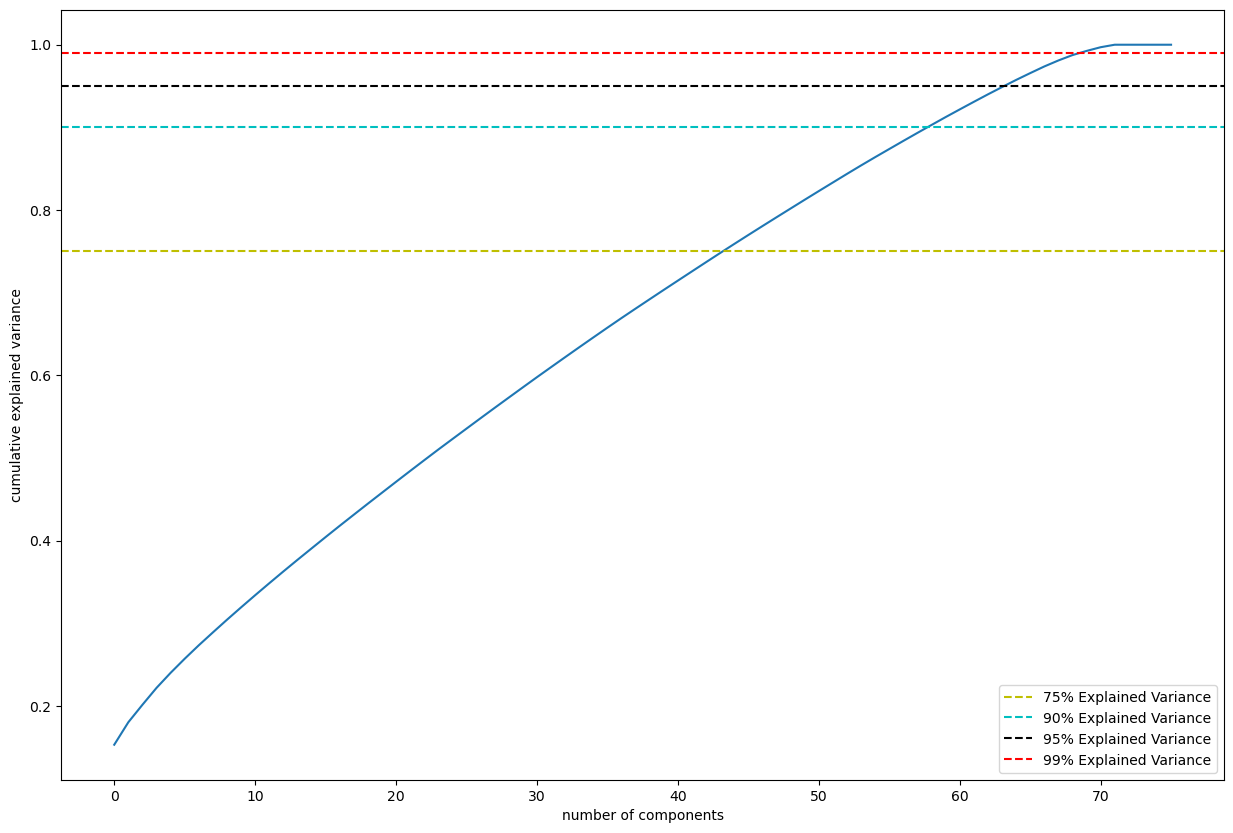

In [187]:
from sklearn.pipeline import Pipeline as Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED))
    ]
)
pipeline.fit(X_train)

### Show the number of the explained variance ratio and the number of components
print(pipeline.named_steps["pca"].explained_variance_ratio_)
print("Number of Components: ", pipeline.named_steps["pca"].n_components_)

### Plot explained variance as a function of number of Components
fig, ax = plt.subplots(1,1, figsize=(15,10), squeeze=False)
ax = plt.plot(np.cumsum(pipeline.named_steps["pca"].explained_variance_ratio_))
### Draw horizontal lines at 0.75, 0.9, 0.95, 0.99
plt.axhline(y = 0.75, color='y', linestyle='--', label = '75% Explained Variance')
plt.axhline(y = 0.90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 0.95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 0.99, color='r', linestyle='--', label = '99% Explained Variance')

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='best')
plt.show()

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [191]:
pca_var_lst = [0.75, 0.90, 0.95, 0.99]
n_comp_lst = []
for i in pca_var_lst:
    pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(i, random_state=RANDOM_SEED))
    ])
    pipeline.fit(X_train)
    n_comp = pipeline.named_steps["pca"].n_components_
    n_comp_lst.append(n_comp)
    print(f"{i*100} % explained variance: {n_comp}")
print(n_comp_lst)

75.0 % explained variance: 45
90.0 % explained variance: 59
95.0 % explained variance: 65
99.0 % explained variance: 70
[45, 59, 65, 70]


In [192]:
pca_rf_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("rforest", RandomForestClassifier(random_state=RANDOM_SEED))
    ]
)

pca_rf_estimator = GridSearchCV(
    estimator=pca_rf_pipeline,
    param_grid = {
        "pca__n_components":[45, 59, 65, 70],
        "rforest__max_depth":[10, 30, 50],
        "rforest__n_estimators":[80, 100, 200],
        # "rforest__bootstrap":[True, False],
        # # "rforest__criterion":["gini", "entropy", "log_loss"]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

pca_rf_estimator.fit(X_train, y_train)
print(f"The best parameters: {pca_rf_estimator.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=80; total time=   3.5s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=80; total time=   3.4s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=80; total time=   3.5s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=100; total time=   4.1s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=100; total time=   4.1s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=100; total time=   4.1s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=200; total time=   8.2s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=200; total time=   8.1s
[CV] END pca__n_components=45, rforest__max_depth=10, rforest__n_estimators=200; total time=   8.2s
[CV] END pca__n_components=45, rforest__m

In [193]:
### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
pca_rf_pipeline.set_params(**pca_rf_estimator.best_params_)
pca_rf_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
pca_rf_pred = pca_rf_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, pca_rf_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, pca_rf_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, pca_rf_pred):.4f}")

Classification Report:
                          precision    recall  f1-score   support

             Accounting       0.03      0.06      0.04        87
            Advertising       0.05      0.05      0.05        96
            Agriculture       0.05      0.05      0.05       101
           Architecture       0.08      0.10      0.09        90
                   Arts       0.01      0.01      0.01       110
             Automotive       0.04      0.04      0.04       106
                Banking       0.02      0.03      0.03        91
                Biotech       0.05      0.05      0.05        96
       BusinessServices       0.02      0.02      0.02        96
              Chemicals       0.04      0.06      0.04        87
   Communications-Media       0.02      0.02      0.02       108
           Construction       0.07      0.05      0.06       110
             Consulting       0.06      0.05      0.05       104
              Education       0.05      0.03      0.03       111


# ohne PCA


In [194]:
rf_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("rforest", RandomForestClassifier(random_state=RANDOM_SEED))
    ]
)

rf_estimator = GridSearchCV(
    estimator=rf_pipeline,
    param_grid = {
        "rforest__max_depth":[10, 30, 50],
        "rforest__n_estimators":[80, 100, 200],
        # "rforest__bootstrap":[True, False],
        # # "rforest__criterion":["gini", "entropy", "log_loss"]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

rf_estimator.fit(X_train, y_train)
print(f"The best parameters: {rf_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
rf_pipeline.set_params(**rf_estimator.best_params_)
rf_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
rf_pred = rf_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, rf_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, rf_pred):.4f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....rforest__max_depth=10, rforest__n_estimators=80; total time=   0.8s
[CV] END ....rforest__max_depth=10, rforest__n_estimators=80; total time=   0.8s
[CV] END ....rforest__max_depth=10, rforest__n_estimators=80; total time=   0.8s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=100; total time=   1.0s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=100; total time=   1.0s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=100; total time=   1.0s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=200; total time=   2.0s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=200; total time=   1.9s
[CV] END ...rforest__max_depth=10, rforest__n_estimators=200; total time=   1.9s
[CV] END ....rforest__max_depth=30, rforest__n_estimators=80; total time=   1.9s
[CV] END ....rforest__max_depth=30, rforest__n_estimators=80; total time=   1.9s
[CV] END ....rforest__max_depth=30, rforest__n_es

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [197]:
lr_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("lr", LogisticRegression(max_iter=10000))
    ]
)

lr_estimator = GridSearchCV(
    estimator=lr_pipeline,
    param_grid = {
        "pca__n_components":[34],
        "lr__penalty": ["l1", "l2", "elasticnet", None]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

lr_estimator.fit(X_train, y_train)
print(f"The best parameters: {lr_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
lr_pipeline.set_params(**lr_estimator.best_params_)
lr_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
lr_pred = lr_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, lr_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, lr_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, lr_pred):.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............lr__penalty=l1, pca__n_components=34; total time=   0.1s
[CV] END ...............lr__penalty=l1, pca__n_components=34; total time=   0.1s
[CV] END ...............lr__penalty=l1, pca__n_components=34; total time=   0.1s
[CV] END ...............lr__penalty=l2, pca__n_components=34; total time=   0.5s
[CV] END ...............lr__penalty=l2, pca__n_components=34; total time=   0.6s
[CV] END ...............lr__penalty=l2, pca__n_components=34; total time=   0.7s
[CV] END .......lr__penalty=elasticnet, pca__n_components=34; total time=   0.2s
[CV] END .......lr__penalty=elasticnet, pca__n_components=34; total time=   0.1s
[CV] END .......lr__penalty=elasticnet, pca__n_components=34; total time=   0.3s
[CV] END .............lr__penalty=None, pca__n_components=34; total time=   0.1s
[CV] END .............lr__penalty=None, pca__n_components=34; total time=   0.2s
[CV] END .............lr__penalty=None, pca__n_co

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


9 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-pa

The best parameters: {'lr__penalty': 'l2', 'pca__n_components': 34}
Classification Report:
                          precision    recall  f1-score   support

             Accounting       0.04      0.09      0.06        87
            Advertising       0.06      0.04      0.05        96
            Agriculture       0.00      0.00      0.00       101
           Architecture       0.02      0.02      0.02        90
                   Arts       0.09      0.04      0.05       110
             Automotive       0.05      0.03      0.04       106
                Banking       0.03      0.07      0.04        91
                Biotech       0.01      0.01      0.01        96
       BusinessServices       0.02      0.01      0.01        96
              Chemicals       0.04      0.38      0.07        87
   Communications-Media       0.07      0.03      0.04       108
           Construction       0.05      0.05      0.05       110
             Consulting       0.00      0.00      0.00       1

In [198]:
kNN_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("kNN", KNeighborsClassifier())
    ]
)

kNN_estimator = GridSearchCV(
    estimator=kNN_pipeline,
    param_grid = {
        "pca__n_components":[34],
        "kNN__n_neighbors": [3, 5, 10, 20, 50],
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

kNN_estimator.fit(X_train, y_train)
print(f"The best parameters: {kNN_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
kNN_pipeline.set_params(**kNN_estimator.best_params_)
kNN_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
kNN_pred = kNN_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, kNN_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, kNN_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, kNN_pred):.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...........kNN__n_neighbors=3, pca__n_components=34; total time=   1.4s
[CV] END ...........kNN__n_neighbors=3, pca__n_components=34; total time=   1.2s
[CV] END ...........kNN__n_neighbors=3, pca__n_components=34; total time=   1.3s
[CV] END ...........kNN__n_neighbors=5, pca__n_components=34; total time=   0.8s
[CV] END ...........kNN__n_neighbors=5, pca__n_components=34; total time=   0.8s
[CV] END ...........kNN__n_neighbors=5, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=10, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=10, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=10, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=20, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=20, pca__n_components=34; total time=   0.8s
[CV] END ..........kNN__n_neighbors=20, pca__n_co